In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib as pl
from configparser import ConfigParser

import pandas as pd

import joblib as jl
import numpy as np
import scipy.stats as sst
from scikit_posthocs import posthoc_dunn
from statsmodels.formula.api import ols
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from src.root_path import config_path, root_path
from src.utils.dataframes import add_classified_contexts
from src.utils.tools import decimate_xy
from src.visualization.palette import *

# context metric distribution and comparison between regions and transition pairs
### Load and format all required data, i.e. a dataframe

In [3]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 20,
        'zscore': True,
        'stim_type': 'permutations',
        }
alpha = 0.05
montecarlos = 11000

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

summary_DF_file = pl.Path(config['paths']['analysis_cache']) / '220520_minimal_DF'

In [4]:
def print_percentage_significant():
    DF = jl.load(summary_DF_file).query(
        "analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric in 'integral' "
        )
    # number proportion of significant instances
    nsignif = np.sum(DF.value.values>0)
    ntotal  = DF.shape[0]
    print(f'{nsignif}/{ntotal}, {nsignif/ntotal*100:.3f}% significant  instances')

    # proportion of neurons with at least one signif instance
    neusig = DF.groupby('id').agg(modulated=('value', lambda x: np.any(x>0)))
    nsignif = np.sum(neusig.modulated.values)
    ntotal  = neusig.shape[0]
    print(f'{nsignif}/{ntotal}, {nsignif/ntotal*100:.3f}% modulated neurons')

print_percentage_significant()

45906/501440, 9.155% significant  instances
1232/2728, 45.161% modulated neurons


In [5]:
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'last_bin']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and source == 'real' and "
                                    f"diff_metric == 'delta_FR' and "
                                    f"value > 0")

DF.loc[DF.metric == 'integral', 'value'] = DF.loc[DF.metric == 'integral', 'value'] /1000  # ms to s for better display

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
print(DF.head())


# pivots for the scatter
pivoted = DF.pivot_table(index=['region', 'site', 'context_pair', 'probe', 'trans_pair', 'id'],
                         columns=['metric'], values='value', aggfunc='first', observed=True).reset_index()

# adds a small amount of jitter to the last bin value to help visualization
binsize = 1 / meta['raster_fs']
jitter = (np.random.random(pivoted.shape[0]) * binsize * 0.8 - (binsize * 0.8 / 2)) * 1000  # in ms
pivoted['last_bin_jittered'] = pivoted['last_bin'] + jitter

print(pivoted.shape)
print(pivoted.head())

(91812, 9)
              id context_pair probe     value    metric diff_metric     site  \
0  TNC013a-019-3        00_01     1  0.181284  integral    delta_FR  TNC013a   
1  TNC013a-036-3        00_01     1  0.337167  integral    delta_FR  TNC013a   
2  TNC013a-042-9        00_01     1  0.192177  integral    delta_FR  TNC013a   
3  TNC013a-046-1        00_01     1  0.134207  integral    delta_FR  TNC013a   
4  TNC013a-036-3        00_02     1  0.346280  integral    delta_FR  TNC013a   

  region    trans_pair  
0     A1  same_silence  
1     A1  same_silence  
2     A1  same_silence  
3     A1  same_silence  
4     A1  diff_silence  
(45906, 9)
metric region     site context_pair probe    trans_pair             id  \
0          A1  TNC013a        00_01     1  same_silence  TNC013a-019-3   
1          A1  TNC013a        00_01     1  same_silence  TNC013a-036-3   
2          A1  TNC013a        00_01     1  same_silence  TNC013a-042-9   
3          A1  TNC013a        00_01     1  same_sil

## scatter plot of all dots

######## full dataset metrics ######## 
LinregressResult(slope=0.00043606027794971034, intercept=0.12776281544795312, rvalue=0.47971149300071986, pvalue=0.0, stderr=3.7226463308916435e-06, intercept_stderr=0.001210202309347121)
time saturated instances: n=667, %=1.4529691107916176
metric      integral      last_bin
count   45906.000000  45906.000000
mean        0.236450    249.250641
std         0.189718    208.706192
min         0.023983     50.000000
25%         0.120628    100.000000
50%         0.181853    200.000000
75%         0.285334    300.000000
max         2.916471   1000.000000


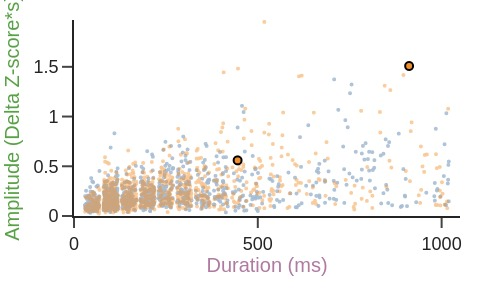

In [6]:
### x, y regression and number of x saturated (x==1000) points
print(f"######## full dataset metrics ######## "
      f"\n{sst.linregress(pivoted.last_bin, pivoted.integral)}"
      f"\ntime saturated instances: n={pivoted.query('last_bin == 1000').shape[0]}, "
      f"%={pivoted.query('last_bin == 1000').shape[0]/pivoted.shape[0] *100}"
      f"\n{pivoted.loc[:, ['integral', 'last_bin']].describe()}")



fig = go.Figure()
maxy = list()
rng = np.random.default_rng(42)
for region in ['A1', 'PEG']:
    toplot = pivoted.query(f"region == '{region}'")
    x = toplot['last_bin_jittered'].values
    y = toplot['integral'].values

    xm, ym = decimate_xy(x, y, end_num=1000, by_quantiles=False, rng=rng)
    maxy.append(np.max(ym))

    fig.add_trace(go.Scatter(x=xm, y=ym,
                                          mode='markers',
                                          opacity=0.5,
                                          marker=dict(
                                              color=REGION_COLORMAP[region],
                                              opacity=0.9,
                                              size=2
                                          ),
                                          name=region,
                                          hoverinfo='skip',
                                          showlegend=False)
                             )

maxy = np.max(maxy)

## highlight the special cell, defined in the first cell of the notebook
# same examples as in figure 1, cellid, (context-pair,), probe
example_cells = [
    ('ARM021b-36-8', (0,1), 3),
    ('ARM021b-36-8', (1,3), 4),
]

for cellid, ctx_pair, probe in example_cells:

    celltoplot = toplot.query(f"id == '{cellid}' and context_pair == '{ctx_pair[0]:02}_{ctx_pair[1]:02}' and "
                              f"probe == {probe}")

    fig.add_trace(go.Scatter(x=celltoplot['last_bin_jittered'],
                                          y=celltoplot["integral"],
                                          mode='markers',
                                          marker=dict(color=REGION_COLORMAP[celltoplot['region'].values[0]],
                                                      size=4,
                                                      line=dict(color='black',
                                                                width=1)),
                                          hoverinfo='skip',
                                          showlegend=False)
                             )

w, h = 2.5, 1.5 # in inches
_ = fig.update_layout(template='simple_white',
                      margin=dict(l=10, r=10, t=10, b=10),
                      width=round(96*w), height=round(96*h),

                      xaxis=dict(
                          range=[0, 1050],
                          title=dict(
                          text='Duration (ms)',
                          standoff=0,
                          font_color=DURCOLOR,
                          font_size=10),
                          tickfont_size=9
                      ),

                      yaxis=dict(
                          range=[0,maxy+maxy*0.01],
                                 title=dict(
                          text="Amplitude (Delta Z-score*s) ",
                          standoff=0,
                          font_color=AMPCOLOR,
                          font_size=10),
                          tickfont_size=9
                      ))


filename = folder / 'fig2_parameter_scatter'
# fig.write_image(filename.with_suffix('.svg'))
fig.show(renderer='jpeg', scale=2)

In [7]:
# count number of instances that are being compared, their mean and standard deviations
inst_by_reg = pivoted.groupby('region', observed=True).agg(inst_count=('integral', 'count'), neu_count=('id', pd.Series.nunique))
print(inst_by_reg)


inst_by_trans = pivoted.groupby('trans_pair', observed=True).agg(inst_count=('integral', 'count'), neu_count=('id', pd.Series.nunique))
print('\n', inst_by_trans)
print('\n',inst_by_reg.sum())


        inst_count  neu_count
region                       
A1           24711        709
PEG          21195        523

               inst_count  neu_count
trans_pair                         
same_silence        1766        725
diff_silence       11242       1019
diff_same           7657        945
diff_diff          25241        991

 inst_count    45906
neu_count      1232
dtype: int64


# simpliffied summary plots

In [8]:
# grand mean across all data, works to normalize metrics across all data, and transform units from
# integral (z-score * ms) into percentage increase in firing rate.
def norm_by_mean(df):
    normalizer =df.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

    df = pd.merge(df, normalizer, on=['metric'], validate="m:1")
    df['norm_val'] = df['value']/df['grand_mean']

    return df

def simplify_classified_contexts(df):
    # the simplest approach is to manually map the 4 categories into onehots
    # onehot order: diff1 diff2 same silence
    # mapper={'diff_diff':(1,1,0,0), 'diff_same':(1,0,1,0), 'diff_silence':(1,0,0,1), 'same_silence':(0,0,1,1)}

    # even simpler encoding
    # onehot order: diff(1 and 2) same silence
    mapper={'diff_diff':(1,0,0), 'diff_same':(1,1,0), 'diff_silence':(1,0,1), 'same_silence':(0,1,1)}

    df['onehot'] = df['trans_pair'].replace(mapper)

    # onehotdf = pd.DataFrame(toregress['onehot'].to_list(), columns = ['diff1', 'diff2', 'same', 'silence'])
    onehotdf = pd.DataFrame(df['onehot'].to_list(), columns = ['diff', 'same', 'silence'])
    df.drop(columns='onehot', inplace=True)
    df = pd.concat([df, onehotdf], axis=1)

    return df

def kruskal_with_posthoc(df, group_col, val_col):
    # pools data in a list of vectors to run kruskal
    to_stat = list()
    for kk in df[group_col].unique():
        to_stat.append(df.loc[df[group_col] == kk, val_col].values)
    kruskal = sst.kruskal(*to_stat)
    print(kruskal)

    # uses the og dataframe to run the pairwise posthoc test
    dunn = posthoc_dunn(df, val_col=val_col, group_col=group_col, p_adjust='bonferroni')
    print(f'Dunn post hoc results\n{dunn}')

    return kruskal, dunn

#### ferrete vocalization
after some quick clasification, it became clear that when a ferret vocalization is used as a contexts,
the contextual effects increase. Here I am trying to merge in those extra classification with that of
transition types, thus creating 5 different caterogires silence same, ferret-same, diff and ferret-diff.

Since I did not make a proper cache of the ferre vocalization information, here I am importing a CSV file generated  by
221205_ferret_vocalization_effects.ipynb at the lab by SVD

fortunately this ferrete DF its pretty much equal as the source DF originally used here, so pluggint it in has
been relatively straightforward

In [9]:
# relevant_cols = ['id', 'context_pair', 'probe', 'value', 'metric', 'region', 'voc_ctx', 'voc_prb']
relevant_cols = ['id', 'region', 'named_ctx_0', 'named_ctx_1', 'named_probe',
                 'context_pair', 'probe', 'voc_ctx', 'voc_prb',
                 'metric', 'value']
ferret_df = pd.read_csv(pl.Path(config['paths']['analysis_cache']) / "230308_ferret_voc.csv",
                        usecols=relevant_cols,
                        dtype={key:('category' if key!='value' else 'float32') for key in relevant_cols})

fprobes = ferret_df['probe'].unique().tolist()
ferret_df['probe'] = ferret_df['probe'].replace({p:int(p) for p in fprobes}) # replace category of str for cat of int

ferret_df = add_classified_contexts(ferret_df)
ferret_df.head()
# confirm that ferret_df has the same data as the full original dataframe
# print(DF.shape)
# print(ferret_df.shape)
# checkmerge = pd.merge( left=DF, right=ferret_df, on=['id','context_pair','probe','metric'], validate='1:1')
# print(checkmerge.shape)
# print(checkmerge.head())

,id,context_pair,probe,value,metric,region,named_probe,named_ctx_0,named_ctx_1,voc_ctx,voc_prb,trans_pair
0,TNC013a-019-3,00_01,1,0.181284,integral,A1,cash_register,silence,cash_register,sound,sound,same_silence
1,TNC013a-036-3,00_01,1,0.337167,integral,A1,cash_register,silence,cash_register,sound,sound,same_silence
2,TNC013a-042-9,00_01,1,0.192177,integral,A1,cash_register,silence,cash_register,sound,sound,same_silence
3,TNC013a-046-1,00_01,1,0.134207,integral,A1,cash_register,silence,cash_register,sound,sound,same_silence
4,TNC013a-019-3,00_01,1,350.000000,last_bin,A1,cash_register,silence,cash_register,sound,sound,same_silence



##### mean and error values by region #####
integral mean±SEM. A1: 0.23±0.001, PEG: 0.25±0.001Z-score*s
last_bin mean±SEM. A1: 244.97±1.357, PEG: 254.25±1.396ms

##### mean and error values by vocalization #####
integral mean±SEM. sound: 0.22±0.0010, vocalization: 0.24±0.0020 Z-score*s
last_bin mean±SEM. sound: 229.37±1.2012, vocalization: 252.92±2.3301 ms

##### mean and error values by transition #####
integral mean±SEM. diff: 0.24±0.0009, same: 0.23±0.0018, silence: 0.28±0.0022 Z-score*s
last_bin mean±SEM. diff: 247.83±0.9858, same: 246.92±2.1641, silence: 287.33±2.1618 ms

######### integral, region #########

KruskalResult(statistic=93.80592795611672, pvalue=3.4802794259140945e-22)
Dunn post hoc results
               A1           PEG
A1   1.000000e+00  3.480279e-22
PEG  3.480279e-22  1.000000e+00

######### integral, transition #########

KruskalResult(statistic=422.1311052850962, pvalue=2.1646872914741717e-92)
Dunn post hoc results
                 diff          same       sile

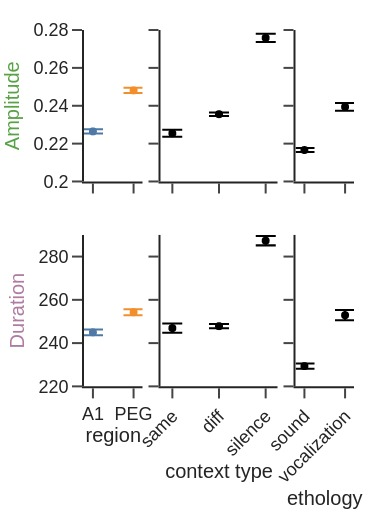

In [22]:
### reclasification by one and only one context
# toregress = norm_by_mean(DF)
toregress = norm_by_mean(ferret_df)
toregress = simplify_classified_contexts(toregress)

#### metrics by region formated for paper
print("\n##### mean and error values by region #####")
toprint = toregress.groupby(['metric', 'region'], observed=True).agg(
    mean=('value', np.mean), std=('value', np.std), sem=('value', sst.sem))
for metric in toprint.index.levels[0]:
    inner = toprint.loc[metric, :]
    str_parts = list()
    for tp, vals in inner.iterrows():
        str_parts.append(f"{tp}: {vals.loc['mean']:.2f}±{vals.loc['sem']:.3f}")

    if metric == 'integral':
        units = 'Z-score*s'
    elif metric == 'last_bin':
        units = 'ms'

    full_str = f'{metric} mean±SEM. ' + ', '.join(str_parts) + units
    print(full_str)

#### metrics by vocalization formated for paper
print("\n##### mean and error values by vocalization #####")
# filters out silence instances to accout for interference interaction with vocalization
toprint = toregress.query('silence == 0').groupby(['metric', 'voc_ctx']).agg(
    mean=('value', np.mean), std=('value', np.std), sem=('value', sst.sem))
for metric in toprint.index.levels[0]:
    inner = toprint.loc[metric, :]
    str_parts = list()
    for tp, vals in inner.iterrows():
        str_parts.append(f"{tp}: {vals.loc['mean']:.2f}±{vals.loc['sem']:.4f}")

    if metric == 'integral':
        units = 'Z-score*s'
    elif metric == 'last_bin':
        units = 'ms'

    full_str = f"{metric} mean±SEM. {', '.join(str_parts)} {units}"
    print(full_str)

toplot = list()  # concatenate data classified on single values
for cat in ['diff', 'same', 'silence']:
    subset = toregress.query(f"{cat} == 1").copy()
    subset['transition'] = cat
    toplot.append(subset)

toplot = pd.concat(toplot)

#### metrics by context pair formated for paper
print("\n##### mean and error values by transition #####")
# filters out the silence vocalization context pairs
toprint = toplot.query("not (transition == 'silence' and voc_ctx == 'vocalization')"
                       ).groupby(['metric', 'transition']).agg(
    mean=('value', np.mean), std=('value', np.std), sem=('value', sst.sem))
for metric in toprint.index.levels[0]:
    inner = toprint.loc[metric, :]
    str_parts = list()
    for tp, vals in inner.iterrows():
        str_parts.append(f"{tp}: {vals.loc['mean']:.2f}±{vals.loc['sem']:.4f}")
    if metric == 'integral':
        units = 'Z-score*s'
    elif metric == 'last_bin':
        units = 'ms'
    full_str = f"{metric} mean±SEM. {', '.join(str_parts)} {units}"
    print(full_str)


def plot_metric_quant_bars(df, metric, category):
    print(f'\n######### {metric}, {category} #########\n')
    df = df.query(f"metric == '{metric}'")

    if category == 'transition':
        ### transitions ###
        df = df.query("not (transition == 'silence' and voc_ctx == 'vocalization')") # filters out the silence vocalization context pairs
        _ = kruskal_with_posthoc(df, group_col='transition', val_col='value')
        df = df.groupby(by=['transition'], observed=True).agg(stat=('value', np.mean),
                                                              err=('value', sst.sem))

        x = ['same', 'diff', 'silence']
        y = [df.at[cat, 'stat'] for cat in x]
        yerr = [df.at[cat, 'err'] for cat in x]
        return [
            go.Scatter(x=x, y=y, mode='markers',
                       marker=dict(color='black',
                                   size=4),
                       error_y=dict(array=yerr,
                                    color='black',
                                    thickness=1,
                                    width=5),
                       showlegend=False)
        ]

    ### regions ###
    elif category == 'region':
        _ = kruskal_with_posthoc(df, group_col='region', val_col='value')
        df = df.groupby('region').agg(stat=('value', np.mean),
                                      err=('value', sst.sem))

        # if you want different color error bars, have to do it one at a time
        reg_quant = list()
        for rr, row in df.iterrows():
            reg_quant.append(go.Scatter(x=(rr,),
                                        y=(row.stat,),
                                        mode='markers',
                                        marker=dict(color=REGION_COLORMAP[rr],
                                                    size=4),
                                        error_y=dict(array=(row.err,),
                                                     color=REGION_COLORMAP[rr],
                                                     thickness=1,
                                                     width=5),
                                        showlegend=False),
                             )

        return reg_quant

    elif category == 'vocalization':
        ### vocalizations ###
        df = df.query('silence == 0') # filtering out silence such that it does not oclude vocalization effects, worth having an interactions plot??
        _ = kruskal_with_posthoc(df, group_col='voc_ctx', val_col='value')
        df = df.groupby(by=['voc_ctx'], observed=True).agg(stat=('value', np.mean),
                                                           err=('value', sst.sem))

        x = ['sound', 'vocalization']
        y = [df.at[cat, 'stat'] for cat in x]
        yerr = [df.at[cat, 'err'] for cat in x]
        return [
            go.Scatter(x=x, y=y, mode='markers',
                       marker=dict(color='black',
                                   size=4),
                       error_y=dict(array=yerr,
                                    color='black',
                                    thickness=1,
                                    width=5),
                       showlegend=False)
        ]


    else:
        raise ValueError(f'bad param {category}')


fig = make_subplots(2, 3, column_width=[0.25, 0.5, 0.25], shared_xaxes='columns', shared_yaxes='rows')
for mm, met in enumerate(['integral', 'last_bin']):
    for cc, (cat, fdf) in \
            enumerate(zip(['region', 'transition', 'vocalization'],
                          [toregress, toplot, toregress])):
        # here consider that the dataframe with duplicated data is only required for transitions, and if
        # used on the vocalizations, it inverts the results since its probably mutiplying silences more than voc
        pan = plot_metric_quant_bars(fdf, met, cat)
        fig.add_traces(pan, cols=[cc + 1] * len(pan), rows=[mm + 1] * len(pan))

w, h = 2, 2.5
w, h = 3.4, 4.6 # scaling acorgin inskcape canvas
w, h = 2, 2*4.6/3.4  # keep aspect ratio above
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),
                  showlegend=False, )

fig.update_xaxes(title=dict(text='region'), col=1, row=2)
fig.update_xaxes(title=dict(text='context type'), tickangle=-45, col=2, row=2)
fig.update_xaxes(title=dict(text='ethology'), tickangle=-45, col=3, row=2)

fig.update_yaxes(title=dict(text="Amplitude", font_color=AMPCOLOR, ),
                 range=[0.2, 0.28],
                 # tickmode='linear', tick0=0.16, dtick=0.04,
                 col=1, row=1)
fig.update_yaxes(title=dict(text='Duration', font_color=DURCOLOR),
                 range=[220, 290],
                 col=1, row=2)

fig.update_xaxes(title_font_size=10, title_standoff=0, tickfont_size=9)
fig.update_yaxes(title_font_size=10, title_standoff=0, tickfont_size=9)

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

filename = folder / 'fig2_transition_region_effects'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

#### multiple linear regression
for completness, copied over from 220818_multiple_categorical_regression.ipynb and with extra regression
considering ferret vocalization as another factor (done separately for ease)

In [11]:
print('\n####### by region #######\n')
for metric in toregress.metric.unique().tolist():
    print(f"\n#### {metric} ####")
    mod = ols("norm_val ~ C(region)", data=toregress.query(f"metric == '{metric}'"))
    res = mod.fit()
    print(res.summary())


####### by region #######


#### integral ####
                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     149.2
Date:                Tue, 16 May 2023   Prob (F-statistic):           2.95e-34
Time:                        13:42:41   Log-Likelihood:                -54954.
No. Observations:               45906   AIC:                         1.099e+05
Df Residuals:                   45904   BIC:                         1.099e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [12]:
print('\n####### by catergory, stephen version #######\n')
for metric in toregress.metric.unique().tolist():
    print(f"\n#### {metric} ####")
    mod = ols("norm_val ~ C(same) + C(silence)", data=toregress.query(f"metric == '{metric}'"))
    res = mod.fit()
    print(res.summary())


####### by catergory, stephen version #######


#### integral ####
                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     354.0
Date:                Tue, 16 May 2023   Prob (F-statistic):          2.83e-153
Time:                        13:42:42   Log-Likelihood:                -54677.
No. Observations:               45906   AIC:                         1.094e+05
Df Residuals:                   45903   BIC:                         1.094e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [13]:
print('\n####### by catergory, mateo version #######\n')
for metric in toplot.metric.unique().tolist():
    print(f"\n#### {metric} ####")
    mod = ols("norm_val ~ C(transition)", data=toplot.query(f"metric == '{metric}'"))
    res = mod.fit()
    print(res.summary())


####### by catergory, mateo version #######


#### integral ####
                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     219.2
Date:                Tue, 16 May 2023   Prob (F-statistic):           1.35e-95
Time:                        13:42:44   Log-Likelihood:                -82576.
No. Observations:               66571   AIC:                         1.652e+05
Df Residuals:                   66568   BIC:                         1.652e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [14]:
print('\n####### by vocalization #######\n')
for metric in toregress.metric.unique().tolist():
    print(f"\n#### {metric} ####")
    mod = ols("norm_val ~ C(voc_ctx)", data=toregress.query(f"metric == '{metric}' "
                                                            # f"and silence == 0"
                                                            ))
    res = mod.fit()
    print(res.summary())


####### by vocalization #######


#### integral ####
                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.176
Date:                Tue, 16 May 2023   Prob (F-statistic):              0.140
Time:                        13:42:45   Log-Likelihood:                -55028.
No. Observations:               45906   AIC:                         1.101e+05
Df Residuals:                   45904   BIC:                         1.101e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

# interaction model
this is the deal: silence and vocalization as contexts increase response amplitude and therefore contextua effects,
at least when compared with other sounds like diff. However, when compared with eachother (silence and voc as contexts)
since both responses are big then the difference is small.

In [15]:
# this is different that what I have done before, in this case using a single column of copmposite classification
# and with the duplicated data as required.
# here duplicating transition and treating vocalization as an othogonal variable
toreg = list()  # concatenate data classified on single values
for cat in ['diff', 'same', 'silence']:
    subset = toregress.query(f"{cat} == 1").copy()
    subset['transition'] = cat
    toreg.append(subset)

toreg = pd.concat(toreg)


print('\n####### by context type and vocalization #######\n')
for metric in toreg.metric.unique().tolist():
    print(f"\n#### {metric} ####")
    # mod = ols("norm_val ~ C(voc_ctx, Treatment(reference='sound')) * C(transition, Treatment(reference='diff'))",
    #           data=toreg.query(f"metric == '{metric}'"))
    # mod = ols("norm_val ~ C(region) * C(voc_ctx) * C(transition)",
    mod = ols("norm_val ~ C(voc_ctx) * C(transition)",
              data=toreg.query(f"metric == '{metric}'"))
    res = mod.fit()
    print(res.summary())


####### by context type and vocalization #######


#### integral ####
                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     94.74
Date:                Tue, 16 May 2023   Prob (F-statistic):          8.62e-100
Time:                        13:42:46   Log-Likelihood:                -82558.
No. Observations:               66571   AIC:                         1.651e+05
Df Residuals:                   66565   BIC:                         1.652e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------

## interaction grid
an attempt at showing all the complexity of context pair interactions considering both context type and vocalization types

In [16]:
# makes compossite classification of context pair and  vocalization, which of the pair is the voc??

def add_ctx_type_voc(DF):
    '''
    variation of add classified contexts when ferret vocalization is available
    add 2 columns specifying each context type + vocalization e.g. diff-voc, or same-nonvoc
    and a 3rd column merging both contexs and handling redundancies e.g. diff-voc_same-nonvoc
    '''
    ctx = np.asarray([row.split('_') for row in DF.context_pair], dtype=int)
    prb = np.asarray(DF.probe, dtype=int)

    # is vocalization??
    vocalizations = ['ferret_fights_Athena-Violet001', 'ferret_fights_Jasmine-Violet001']
    voc0 = DF.named_ctx_0.isin(vocalizations).values
    voc1 = DF.named_ctx_1.isin(vocalizations).values
    voc = np.stack([voc0, voc1], axis=1)

    silence = ctx == 0
    same = ctx == prb[:,None]
    different = np.logical_and(~silence, ~same)

    name_arr = np.full_like(ctx, np.nan, dtype=object)

    # silence cannot be a vocalization, omits
    name_arr[np.logical_and(silence, ~voc)] = f'silence'

    for voc_bool, voc_txt in zip([voc, np.logical_not(voc)], ['-voc','-nonvoc']):
        name_arr[np.logical_and(same,voc_bool)] = f'same{voc_txt}'
        name_arr[np.logical_and(different,voc_bool)] = f'diff{voc_txt}'

    DF['class_ctx_0'] = name_arr[:,0]
    DF['class_ctx_1'] = name_arr[:,1]

    # sort  along col axis to equate diff-same with same-diff
    name_arr = np.sort(name_arr, axis=1)

    DF['class_pair'] = ['_'.join(sorted(x)) for x in name_arr]

    for col_name in ['class_ctx_0', 'class_ctx_0', 'class_pair']:
        DF[col_name] = DF[col_name].astype('category')

    return DF

ferret_df = add_ctx_type_voc(ferret_df)
ferret_df.head()

,id,context_pair,probe,value,metric,region,named_probe,named_ctx_0,named_ctx_1,voc_ctx,voc_prb,trans_pair,class_ctx_0,class_ctx_1,class_pair
0,TNC013a-019-3,00_01,1,0.181284,integral,A1,cash_register,silence,cash_register,sound,sound,same_silence,silence,same-nonvoc,same-nonvoc_silence
1,TNC013a-036-3,00_01,1,0.337167,integral,A1,cash_register,silence,cash_register,sound,sound,same_silence,silence,same-nonvoc,same-nonvoc_silence
2,TNC013a-042-9,00_01,1,0.192177,integral,A1,cash_register,silence,cash_register,sound,sound,same_silence,silence,same-nonvoc,same-nonvoc_silence
3,TNC013a-046-1,00_01,1,0.134207,integral,A1,cash_register,silence,cash_register,sound,sound,same_silence,silence,same-nonvoc,same-nonvoc_silence
4,TNC013a-019-3,00_01,1,350.000000,last_bin,A1,cash_register,silence,cash_register,sound,sound,same_silence,silence,same-nonvoc,same-nonvoc_silence


In [17]:
# extract data and turns into a square matrix for plotting

ctx_class = ['silence', 'same-nonvoc', 'diff-nonvoc', 'same-voc', 'diff-voc']
n_instances = ferret_df.query("metric == 'integral'").shape[0]
meandf = ferret_df.groupby(['metric', 'class_pair']).agg(
    mean=('value', 'mean'),
    count=('value', 'count'),
    fract=('value', lambda x: x.shape[0]/n_instances*100))
# print(meandf)
amp_arr = np.full([len(ctx_class), len(ctx_class)], fill_value=np.nan)
dur_arr = np.full([len(ctx_class), len(ctx_class)], fill_value=np.nan)

count_arr = np.full([len(ctx_class), len(ctx_class)], fill_value=np.nan)
frac_arr = np.full([len(ctx_class), len(ctx_class)], fill_value=np.nan)
name_arr = np.full([len(ctx_class), len(ctx_class)], fill_value=np.nan, dtype=object)

for i, ctx0 in enumerate(ctx_class):
    for j, ctx1 in enumerate(ctx_class):
        composite = [ctx0, ctx1]
        composite.sort()
        composite = '_'.join(composite)
        # print(composite)
        indf = meandf.query(f"class_pair == '{composite}'")
        name_arr[i,j] = composite # make sure things are lining up
        if indf.empty:
            continue
        if i>=j:
            amp_arr[i,j] = indf.loc['integral','mean'].values
            frac_arr[i,j] = indf.loc['last_bin','fract'].values
        if i<=j:
            dur_arr[i,j] = indf.loc['last_bin','mean'].values
            count_arr[i,j] = indf.loc['integral','count'].values
print(amp_arr)
print(dur_arr)
# print(name_arr)

[[       nan        nan        nan        nan        nan]
 [0.26261577        nan        nan        nan        nan]
 [0.27791941 0.21464576 0.21720278        nan        nan]
 [0.21946304        nan 0.22980328        nan        nan]
 [0.24071921 0.2256967  0.24330793 0.17103846 0.10532691]]
[[         nan 285.55145264 287.60574341 276.92306519 261.58114624]
 [         nan          nan 235.25585938          nan 244.2713623 ]
 [         nan          nan 227.5987854  251.65036011 254.7454071 ]
 [         nan          nan          nan          nan 200.        ]
 [         nan          nan          nan          nan 108.33333588]]


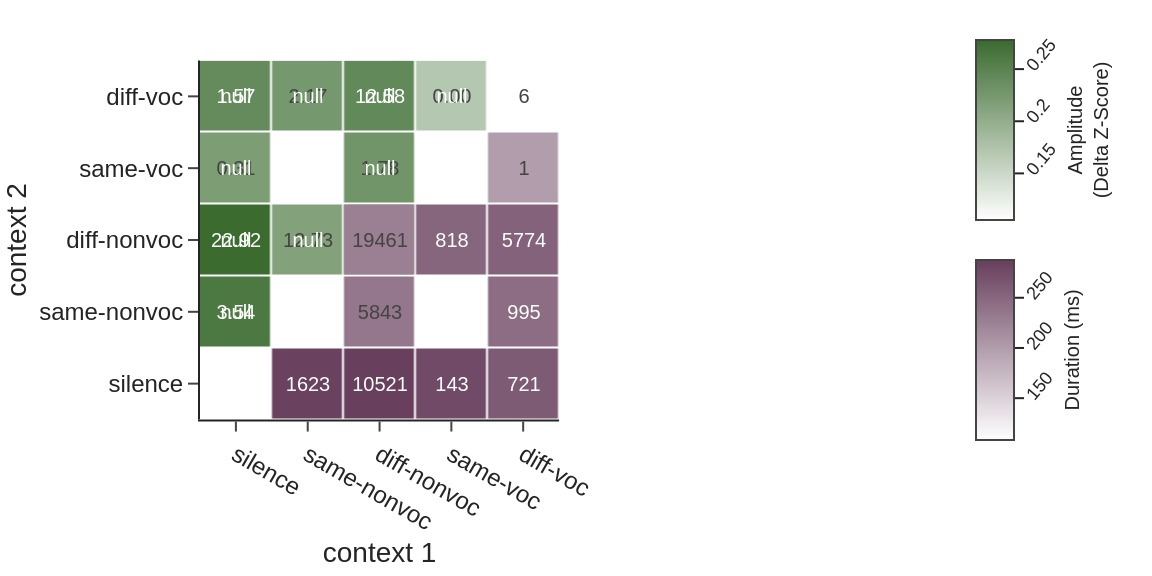

In [18]:
import plotly.colors as pc
#the key point here is that data that is not showing is being set to NaN

fig = make_subplots(1, 2, shared_xaxes='all', shared_yaxes='all', horizontal_spacing=0.05, vertical_spacing=0.05)

for cc, (Z, txt) in enumerate(zip([amp_arr, dur_arr], [frac_arr, count_arr])):
    if cc == 0:
        coloraxis = 'coloraxis'
        texttemplate = '%{text:.2f}'
    else:
        coloraxis = f'coloraxis{cc + 1}'
        texttemplate = '%{text}'
    f = go.Figure()
    f.add_trace(go.Heatmap(z=Z,
                           x=ctx_class,
                           y=ctx_class,
                           xgap=1, ygap=1,
                           coloraxis=coloraxis,
                           ))

    # here text has to be passed as a DF with context and probes as indices and columns
    text_df = pd.DataFrame(data=txt, index=ctx_class, columns=ctx_class)

    f.update_traces(text=text_df,
                    texttemplate=texttemplate,
                    )

    # fig.add_traces(f.data, rows=[1] * len(f.data), cols=[cc + 1] * len(f.data))  # split in two pannels
    fig.add_traces(f.data, rows=[1] * len(f.data), cols=[1] * len(f.data)) # overlay in a sinlge pannel



# amp_cscale = pc.make_colorscale(['#FFFFFF', AMPCOLOR])
# dur_cscale = pc.make_colorscale(['#FFFFFF', DURCOLOR])

# darker verions of the colors above
amp_cscale = pc.make_colorscale(['#FFFFFF', '#3B6B2F'])
dur_cscale = pc.make_colorscale(['#FFFFFF', '#683F5D'])

fig.update_layout(template='simple_white',
                  margin=dict(t=10, b=10, l=10, r=10),
                  width=6 * 96, height=3 * 96,
                  coloraxis=dict(showscale=True,
                                 colorscale=amp_cscale,
                                 colorbar=dict(orientation='v',
                                               thicknessmode='fraction',
                                               thickness=0.05,
                                               lenmode='fraction',
                                               len=0.5,
                                               title=dict(text='Amplitude<br>(Delta Z-Score)',
                                                          side='right',
                                                          font_size=10),
                                               ticklen=5,
                                               tickangle=-50,
                                               tickfont_size=9,
                                               xanchor='left', x=1,
                                               yanchor='top', y=1
                                               )
                                 ),
                  coloraxis2=dict(showscale=True,
                                  colorscale=dur_cscale,
                                  colorbar=dict(orientation='v',
                                                thicknessmode='fraction',
                                                thickness=0.05,
                                                lenmode='fraction',
                                                len=0.5,
                                                title=dict(text='Duration (ms)',
                                                           side='right',
                                                           font_size=10),
                                                ticklen=5,
                                                tickangle=-50,
                                                tickfont_size=9,
                                                xanchor='left', x=1,
                                                yanchor='top', y=0.5
                                                ),
                                  )
                  )

fig.update_yaxes(scaleanchor='x', constrain='domain')
fig.update_yaxes(title_text='context 2', title_standoff=0, col=1, row=1)
fig.update_xaxes(constrain='domain', title_text='context 1', title_standoff=0)

filename = folder / 'fig2_all_context_pairs'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

In [19]:
dur_cscale

[[0.0, '#FFFFFF'], [1.0, '#683F5D']]

# ferret voc probe effects
just for completeness and to ad as a potential extra figure (or just report the data)


##### mean and error values by vocalization #####
integral mean±SEM. sound: 0.24±0.0009, vocalization: 0.23±0.0030 Z-score*s
last_bin mean±SEM. sound: 249.64±1.0281, vocalization: 245.61±3.0393 ms

######### integral voc_prb #########

KruskalResult(statistic=26.001541997910866, pvalue=3.411447707770549e-07)
Dunn post hoc results
                     sound  vocalization
sound         1.000000e+00  3.411448e-07
vocalization  3.411448e-07  1.000000e+00

data summary stats
                   stat       err  count
voc_prb                                
sound         0.237010  0.000926  41502
vocalization  0.231186  0.003010   4404

######### last_bin voc_prb #########

KruskalResult(statistic=0.008835579747539153, pvalue=0.9251109324757422)
Dunn post hoc results
                 sound  vocalization
sound         1.000000      0.925111
vocalization  0.925111      1.000000

data summary stats
                     stat       err  count
voc_prb                                  
sound        

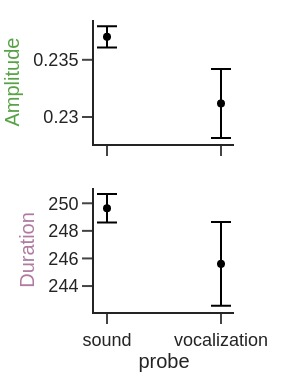

In [20]:
def plot_metric_quant_bars(df, metric, category):
    print(f'\n######### {metric} {category} #########\n')
    df = df.query(f"metric == '{metric}'")


    _ = kruskal_with_posthoc(df, group_col=category, val_col='value')
    df = df.groupby(by=category, observed=True).agg(stat=('value', np.mean),
                                                    err=('value', sst.sem),
                                                    count=('value', 'count'))

    print('\ndata summary stats\n', df)

    x = ['sound', 'vocalization']
    y = [df.at[cat, 'stat'] for cat in x]
    yerr = [df.at[cat, 'err'] for cat in x]
    return [
        go.Scatter(x=x, y=y, mode='markers',
                   marker=dict(color='black',
                               size=4),
                   error_y=dict(array=yerr,
                                color='black',
                                thickness=1,
                                width=5),
                   showlegend=False)
    ]


print("\n##### mean and error values by vocalization #####")
toprint = toregress.groupby(['metric', 'voc_prb']).agg(
    mean=('value', np.mean), std=('value', np.std), sem=('value', sst.sem))
for metric in toprint.index.levels[0]:
    inner = toprint.loc[metric,:]
    str_parts = list()
    for tp, vals in inner.iterrows():
        str_parts.append(f"{tp}: {vals.loc['mean']:.2f}±{vals.loc['sem']:.4f}")
    if metric == 'integral':
        units = 'Z-score*s'
    elif metric == 'last_bin':
        units = 'ms'
    full_str = f"{metric} mean±SEM. {', '.join(str_parts)} {units}"
    print(full_str)


fig = make_subplots(2, 1, shared_xaxes='columns', shared_yaxes='rows')
for mm, met in enumerate(['integral', 'last_bin']):
    pan = plot_metric_quant_bars(toregress, met, 'voc_prb')
    fig.add_traces(pan, cols=[1] * len(pan), rows=[mm + 1] * len(pan))

fig.update_layout(template='simple_white',
                  height=96 * 2, width=96 * 1.5,

                  margin=dict(l=10, r=10, t=10, b=10),
                  xaxis2=dict(title=dict(text='probe')),
                  yaxis=dict(title=dict(text="Amplitude", font_color=AMPCOLOR)),
                  yaxis2=dict(title=dict(text='Duration', font_color=DURCOLOR)),

                  showlegend=False,
                  )

fig.update_xaxes(title_font_size=10, title_standoff=0, tickfont_size=9)
fig.update_yaxes(title_font_size=10, title_standoff=0, tickfont_size=9)

filename = folder / 'sup_fig1_voc_probe'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

In [21]:
print('\n####### by vocalization if in probe #######\n')
for metric in toregress.metric.unique().tolist():
    print(f"\n#### {metric} ####")
    mod = ols("norm_val ~ C(voc_prb)", data=toregress.query(f"metric == '{metric}' "
                                                            ))
    res = mod.fit()
    print(res.summary())


####### by vocalization if in probe #######


#### integral ####
                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.752
Date:                Tue, 16 May 2023   Prob (F-statistic):             0.0527
Time:                        13:42:49   Log-Likelihood:                -55027.
No. Observations:               45906   AIC:                         1.101e+05
Df Residuals:                   45904   BIC:                         1.101e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------